In [10]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import xarray as xr
import pandas as pd

import glob, re
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

# Plotting libraries
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import geopandas as gpd
import matplotlib.pyplot as plt 
from shapely.geometry import box

In [14]:
import regionmask
from dateutil.relativedelta import relativedelta


In [15]:
def decode_times(ts):
    
    # Method to manually decode times
    
    inc = re.sub(" .+", "", ts.time.units)
    startdate = pd.Timestamp(re.sub(".+since ", "", ts.time.units)+' 00:00:00.000000').to_pydatetime()
    
    if inc == "years":
        new_times = [np.datetime64(startdate + relativedelta(years = i)) for i in range(len(ts.time))]
    elif inc == "months":
        new_times = [np.datetime64(startdate + relativedelta(months = i)) for i in range(len(ts.time))]
    else:
        print("TBD: " +inc)
        return
        
    ts = ts.assign_coords(time = new_times)
    
    return ts

def wrap_lon(ds):
    
    # method to 'wrap' longitudes from (0,360) to (-180,180) & sort into ascending order
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds

timeseries of CPC and ERA5

In [52]:
#read era, calculate ts and tx10d
dera = wrap_lon(decode_times(xr.open_dataset("data/era5_tmax_daily_extended_-90--30E_-60-20N_12_mean_0.nc", decode_times = False)))
land_110 = regionmask.defined_regions.natural_earth_v5_0_0.land_110
dera_mask = land_110.mask_3D(dera)
dera_land=dera.where(dera_mask == 1).squeeze(drop = True)

new_lons = slice(-63,-41); new_lats = slice(-28,-11)

era_ts=dera_land.tmax.sel(lat=new_lats,lon=new_lons).mean(dim=('lon','lat'))

def is_as(month):
    return (month >= 8) & (month <= 9)
# compute time series - annual maximum of AS tmax
ndays = 10
era_ts_nday_max = era_ts.rolling(time = ndays,center=False).mean().sel(time=is_as(era_ts['time.month'])).resample(time='AS').max()




In [ ]:
#read cpc, calculate ts and tx10d
dob=wrap_lon(xr.open_dataset("tmax_CPC_daily_Global.V1.0_1979_2023.nc"))

cpc_ts=dob.tmax.sel(lat=new_lats,lon=new_lons).mean(dim=('lon','lat'))
# compute time series - annual maximum of AS tmax
ndays = 10
cpc_ts_nday_max = cpc_ts.rolling(time = ndays,center=False).mean().sel(time=is_as(cpc_ts['time.month'])).resample(time='AS').max()



Station data

In [31]:
sp_st= pd.read_csv('data/dados_83781_D_1961-01-01_2023-09-30.csv',skiprows=11,sep = ";",header = None, index_col = 0, names = ["date","tmax","null"])
sp_st=sp_st.drop('null',1)
sp_st.index = pd.to_datetime(sp_st.index)

In [32]:
sp_st.tmax.describe()

count    22144.000000
mean        25.501608
std          4.361521
min          8.700000
25%         22.600000
50%         25.900000
75%         28.800000
max         37.800000
Name: tmax, dtype: float64

In [102]:
sp_st_cb = sp_st.rolling(10,center=False, min_periods = 8).mean().loc[[m in [8,9] for m in sp_st_ts_nday_max.index.month]].dropna(axis = 0, how = "any").resample('AS').max()

In [103]:
sp_st_cb

,tmax
date,
1961-01-01,30.96
1962-01-01,26.87
1963-01-01,32.20
1964-01-01,27.90
1965-01-01,29.62
...,...
2019-01-01,32.30
2020-01-01,NaN
2021-01-01,31.18


In [107]:
sp_st_ts_nday_rec_aug_sep_max

date
1979-01-01    29.16
1980-01-01    26.34
1981-01-01    29.01
1982-01-01    27.81
1983-01-01    28.79
1984-01-01    27.30
1985-01-01    28.40
1986-01-01    27.54
1987-01-01    26.63
1988-01-01    29.45
1989-01-01    26.11
1990-01-01    24.76
1991-01-01    26.99
1992-01-01    24.89
1993-01-01    27.29
1994-01-01    29.79
1995-01-01    29.84
1996-01-01    26.14
1997-01-01    29.35
1998-01-01    29.28
1999-01-01    30.64
2000-01-01    27.56
2001-01-01    28.28
2002-01-01    28.89
2003-01-01    27.88
2004-01-01    31.78
2005-01-01    27.89
2006-01-01    29.59
2007-01-01    29.96
2008-01-01    28.64
2009-01-01    27.61
2010-01-01    30.26
2011-01-01    27.65
2012-01-01    30.91
2013-01-01    28.84
2014-01-01    30.22
2015-01-01    33.46
2016-01-01    27.92
2017-01-01    31.61
2018-01-01    28.91
2019-01-01    32.30
2020-01-01      NaN
2021-01-01    31.18
2022-01-01      NaN
2023-01-01    34.08
Freq: AS-JAN, Name: tmax, dtype: float64

In [34]:
sp_st_ts_nday_max = sp_st.tmax.rolling(ndays,center=False).mean()

In [35]:
sp_st_ts_nday_rec = sp_st_ts_nday_max['1979-01-01':'2023-09-30']

In [43]:
sp_st_ts_nday_rec_aug_sep=sp_st_ts_nday_rec[(sp_st_ts_nday_rec.index.month>=8) & (sp_st_ts_nday_rec.index.month<=9)]

In [44]:
sp_st_ts_nday_rec_aug_sep_max=sp_st_ts_nday_rec_aug_sep.resample('AS').max()

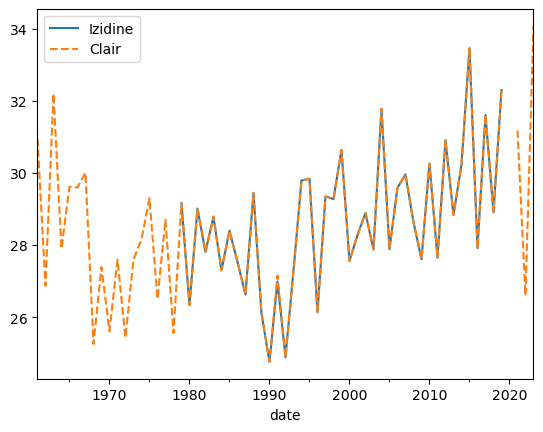

In [113]:
sp_st_ts_nday_rec_aug_sep_max.plot()
sp_st_cb.plot(ax = plt.gca(), ls = "--")
plt.legend(["Izidine", "Clair"])

In [46]:
sp_st_cb

date
1961-01-01    30.96
1962-01-01    26.87
1963-01-01    30.04
1964-01-01    27.90
1965-01-01    29.62
              ...  
2019-01-01    32.30
2020-01-01      NaN
2021-01-01    31.18
2022-01-01      NaN
2023-01-01    34.08
Freq: AS-JAN, Name: tmax, Length: 63, dtype: float64

In [61]:
#Latitude: -23.49638888
#Longitude: -46.61999999
era5_sp_st=dera_land.tmax.sel(lat=-23.496,lon=-46.61,method="nearest")
era5_sp_st=era5_sp_st.sel(time = slice("1979", "2023"))
# cpc_sp_st=dob.tmax.sel(lat=-23.496,lon=-46.61,method="nearest")

In [73]:
tx10_era5_sp_st = dera.tmax.rolling(time = ndays,center=False).mean().sel(time=is_as(dera['time.month'])).resample(time='AS').max().sel(lat=-23.496,lon=-46.61,method="nearest")
# tx10_cpc_sp_st = cpc_sp_st.rolling(time = ndays,center=False).mean().sel(time=is_as(cpc_sp_st['time.month'])).resample(time='AS').max()

Text(0.5, 1.0, 'Tmax 10day average maximum Aug-Sep')

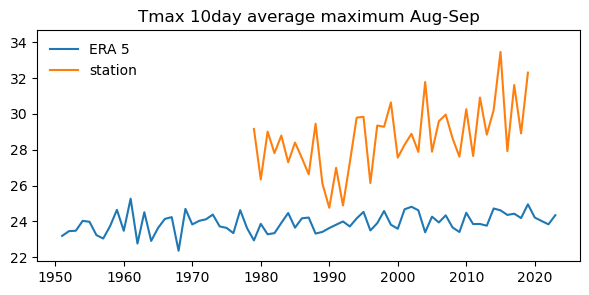

In [74]:
fig, ax = plt.subplots(figsize=(7,3), dpi = 100) 
ax.plot(tx10_era5_sp_st.time.dt.year, tx10_era5_sp_st,label="ERA 5")
# ax.plot(years,tx10_cpc_sp_st,label="CPC")
ax.plot(sp_st_ts_nday_rec_aug_sep_max.index.year, sp_st_ts_nday_rec_aug_sep_max,label="station")
ax.legend(edgecolor = "w")
plt.title("Tmax 10day average maximum Aug-Sep")